# Missing NaNs in driftmap output

- I just re-ran my MLDP tests and I’m still getting output with NaNs at the end of each track. 

- I see the NaNs at the end of the track for both the file in the output/ directory as well as for the raw mldp output files (ie, mldp_trajectories.nc file in runs/), which means that it's not being added by the trimming. 

- The output created when running on the develop branch (ie, the old trimming method) has NaNs at the end of all the tracks except one (track 76). This includes cases where the track is in the middle of the bbox (ie, tracks that have no reason to have a NaN at the end since they would not have been trimmed).

- Track 76 is one of the tracks that are trimmed using the new trimming method. So, in the case of the output created when running on the new branch all of the tracks end in NaN.

- The reason why you didn’t see the same behavior in your output was likely that it doesn’t happen in all the cases. The drift-tool driftmap_mldp_no_preprocess example produces output for 3 days (ciops-e_ml_2021102000_P2D/, ciops-e_ml_2021102100_P2D/, and ciops-e_ml_2021102200_P2D/). The only date where the issue was present was in my output was ciops-e_ml_2021102100_P2D/ and so the histograms are successfully generated on the other two days.

- The output from the drift-tool example that we use for opendrift_nemo_cgrid didn't seem to have the NaN values either, but it may be that it doesn't encounter whatever edge case is prompting the error in the MLDP example.

### On my new branch: 
- I ran  `/fs/vnas_Hdfo/dpnm/jeh326/dfo-drift-projection/drift-analysis/jen/general_dwt_tests/jobsub_scripts/run_driftmap_mldp_dwtgt.sh`, which calls a copy of the drift-tool example runscript with some unimportant modifications (`/fs/vnas_Hdfo/dpnm/jeh326/dfo-drift-projection/drift-tool/examples/DriftMap/run_driftmap-sims_mldp_assemble_only.sh`).
- I’m also pointing at the drift-tool example config file: `/fs/vnas_Hdfo/dpnm/jeh326/dfo-drift-projection/drift-tool/examples/DriftMap/config_dm-sims_mldp_no_preprocess.yaml`
- My output is stored in: `/gpfs/fs7/dfo/dpnm/jeh326/projects/output_general_dwt_tests/driftmap_mldp_dwtgt`
- The screen output from the experiment is here: `/gpfs/fs7/dfo/dpnm/jeh326/projects/output_general_dwt_tests/logs/driftmap_mldp_dwtgt_screen.out`

### After switching back to the develop branch:
- I ran `/fs/vnas_Hdfo/dpnm/jeh326/dfo-drift-projection/drift-analysis/jen/general_dwt_tests/jobsub_scripts/run_driftmap_mldp_dev.sh`, which calls the same runscript as above.
- I’m still pointing at the same drift-tool example config file as above.
- My output is stored in: /gpfs/fs7/dfo/dpnm/jeh326/projects/output_general_dwt_tests/driftmap_mldp_dev
- The screen output from the experiment is here: `/gpfs/fs7/dfo/dpnm/jeh326/projects/output_general_dwt_tests/logs/driftmap_mldp_dev_screen.out`

## notes on the bbox:

- the initial-bbox in the config file is: `'-54.0 45.0 -44.0 52.0'`. This is what's used to set up the initial seeding grid of starting positions. 

- Before the preprocessing stage, an additional half of a degree buffer is added to the bbox by `driftutils.adjust_bbox.adjust_bbox()`. The intention of this step was to make sure that no points in the seeding grid fall on the very edge of the domain. It also makes sure that the bbox being fed to the MLDP preprocessing has a chance of actually covering the full track. This changes the bbox that will be used to `'-54.5, -43.5, 44.5, 52.5'`

- No further changes are made to the bbox using the new trimming method, so printing the bbox in `keep_in_domain.find_boundary()` on the new branch gives: `'-54.5, -43.5, 44.5, 52.5'`.

- Printing the bbox at the beginning of `keep_in_domain.point_outside_bbox()` on the develop branch also gives: `-54.5 44.5 -43.5 52.5`. But, at the last minute, the dev branch adds an additional half of a degree buffer in the step where it checks to see if a point is in or out of the bbox (this is the extra buffer that I forgot about!!). This changes the buffer that is actually used to trim the tracks to: `'-55.0, -43.0, 44.0, 53.0'`. 

- I suspect that the original intention of the added buffer in `keep_in_domain.point_outside_bbox()` might have been to remove the half of a degree buffer, not to add an extra half of a degree. There's a comment in that function, which says: "This might be too restrictive for DriftMap? Maybe I should define a bbox that is slightly smaller than the actual bbox?". As it is, no trimming will happen in this case because the added buffer pushes the bbox out past the range of the ocean data that was preprocessed by MLDP.

In [22]:
import numpy as np
import os
%matplotlib inline
import shapely
from shapely.geometry import Polygon, Point
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from shapely.geometry import Point, Polygon
from matplotlib.path import Path
import matplotlib.pyplot as plt
import datetime
from geopy.distance import distance
import pandas as pd
import geopy.distance


def load_ds(file):
    with xr.open_dataset(file) as ds:
        return ds


projdir = "C:/Users/HoldenJe/Drift\projects/driftmap_update/issue83_slow_predictions/reruns/"

# These outputs were created when running on the develop branch
bbox_dev = [-55.0, -43.0, 44.0, 53.0]
dev_rawfile = os.path.join(projdir, "dev_mldp_trajectories.nc")
dev_outfile = os.path.join(projdir, "dev_ciops-e_ml_2021102100_P2D.nc")
dev = load_ds(dev_outfile)
dev_raw = load_ds(dev_rawfile)

# these outputs were created when running on the branch with the new trimming method
bbox_new = [-54.5, -43.5, 44.5, 52.5]
new_rawfile = os.path.join(projdir, "new_mldp_trajectories.nc")
new_outfile = os.path.join(projdir, "new_ciops-e_ml_2021102100_P2D.nc")
new = load_ds(new_outfile)
new_raw = load_ds(new_rawfile)

## Plot all the tracks

In [20]:
def create_tracklist(ds, rawds):
    tracklist = []
    trimmed_one_track = []
    for track in ds['model_run'].values:
        lons = [t for t in ds.mod_lon.values[track] if not np.isnan(t)]
        rawlons = [t for t in rawds.lon.values[track] if not np.isnan(t)]
        num_trimmed_lons = len(rawlons) - len(lons)
        if len(lons) != len(rawlons):
            if len(lons) > 1:
                if num_trimmed_lons == 1:
                    trimmed_one_track.append(track)
                if num_trimmed_lons > 1:
                    tracklist.append(track)
    return tracklist


def plot_tracks(ds, rawds, rtype, bbox=None):
        
    lons = ds.mod_lon.values
    lats = ds.mod_lat.values
    tracklist = create_tracklist(ds, rawds)
        
    fig = plt.figure(figsize=(14, 14))
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
    ax.add_feature(cfeature.LAND, facecolor='lightgray')
    
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'rotation': 45}
    
    if bbox:
        bbox_lons = [bbox[0], bbox[1], bbox[1], bbox[0], bbox[0]]
        bbox_lats = [bbox[3], bbox[3], bbox[2], bbox[2], bbox[3]]
        plt.plot(bbox_lons, bbox_lats, color='red')

    for r in range(0, len(lons)):
        col = 'blue'
        text_weight = None
        if r in tracklist:
            col = 'red'
            text_weight = 'bold'
        
        plt.plot(lons[r], lats[r], color=col, linestyle='-', linewidth=1)
        plt.text(lons[r][0], lats[r][0], str(r), weight=text_weight)
        
    plt.title(rtype + ' (tracks with more than one point trimmed in red)\ntrimmed tracks: ' + str(tracklist))
    #print('saving ' + str(os.path.join(projdir, str(rtype) + '.png')))
    plt.savefig(os.path.join(projdir, rtype), dpi=500)
    plt.show()

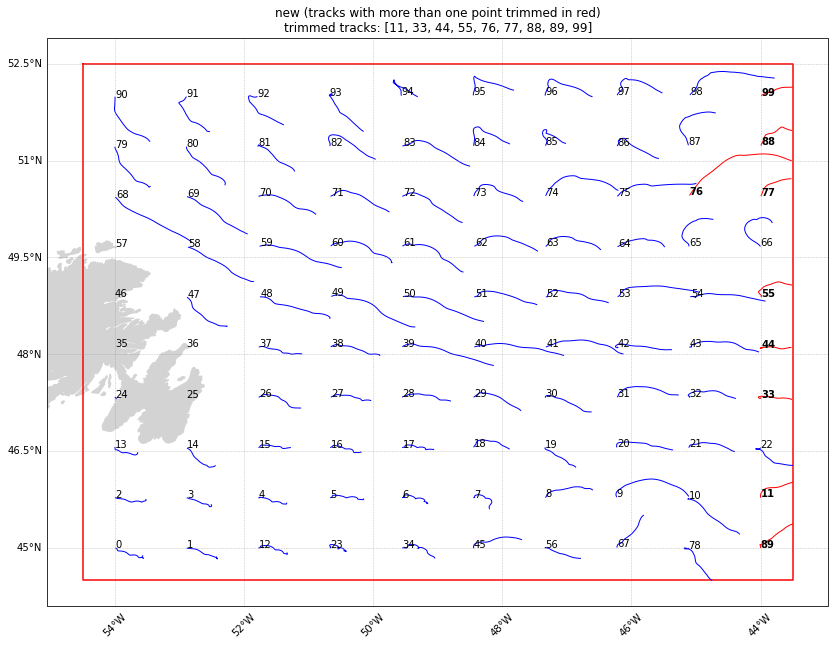

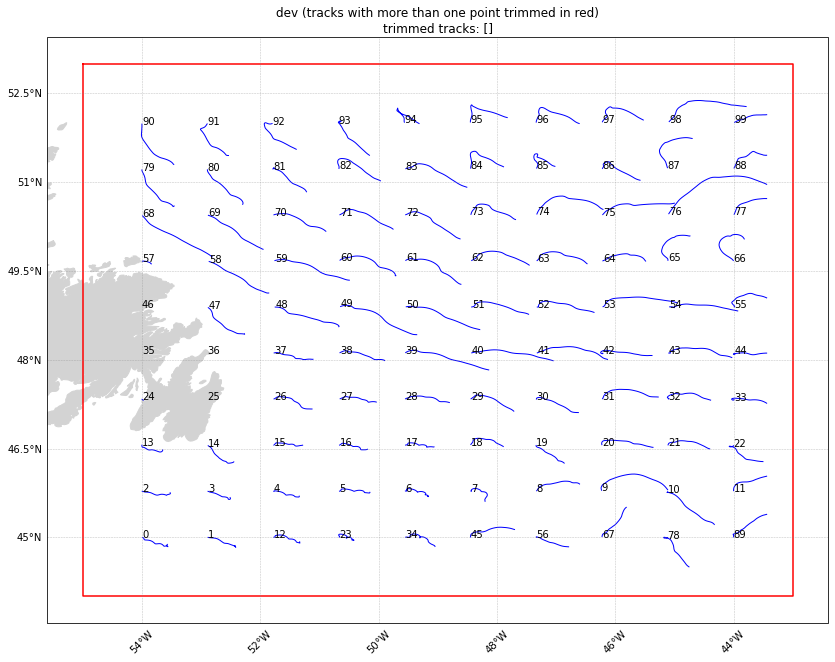

In [21]:
plot_tracks(new, new_raw, 'new', bbox=bbox_new)
plot_tracks(dev, dev_raw, 'dev', bbox=bbox_dev)

## compare the final timesteps of each track and look at the comparison between tracks for any tracks that have been trimmed

In [23]:
def compare_final_tsteps(ds1, ds2, ds1_name, ds2_name, tst=-1):
    
    num_mod_runs = len(ds1.mod_lon.values)
    tstepdict = {ds1_name + '_lons': [], ds1_name + '_lats': [],
                 ds2_name + '_lons': [], ds2_name + '_lats': []}
    
    for r in range(0, num_mod_runs):

        ds1_lons = ds1.mod_lon.values[r]
        ds1_lats = ds1.mod_lat.values[r]
        ds1_time = ds1.time.values
        ds2_lons = ds2.mod_lon.values[r]
        ds2_lats = ds2.mod_lat.values[r]
        ds2_time = ds2.time.values

        tdict = {ds1_name + '_lons': ds1_lons[tst], ds1_name + '_lats': ds1_lats[tst],
                 ds2_name + '_lons': ds2_lons[tst], ds2_name + '_lats': ds2_lats[tst]}
        
        for key in tdict.keys():
            tstepdict[key].append(tdict[key])
            
    tstepdf = pd.DataFrame(tstepdict)
    tstepdf.index.names = ['model_run']
    
    return tstepdf


def compare_trimmed_track_differences(ds1, ds2, ds1_name, ds2_name):
    
    num_mod_runs = len(ds1.mod_lon.values)
    
    for r in range(0, num_mod_runs):

        ds1_lons = ds1.mod_lon.values[r]
        ds1_lats = ds1.mod_lat.values[r]
        ds1_time = ds1.time.values
        ds2_lons = ds2.mod_lon.values[r]
        ds2_lats = ds2.mod_lat.values[r]
        ds2_time = ds2.time.values

        trackdict = {ds1_name + '_lons': ds1_lons, ds1_name + '_lats': ds1_lats,
                     ds2_name + '_lons': ds2_lons, ds2_name + '_lats': ds2_lats}
        
        df = pd.DataFrame(trackdict)
        #df.dropna(axis=0, how='all', thresh=None, subset=None, inplace=True)
        df.index.names = ['tstep']
        checkdf = df.copy()
        checkdf.dropna(axis=0, how='all', thresh=None, subset=None, inplace=True)
        
        def equals(l1, l2):
            for u, v in zip(l1, l2):
                if u is not v and u != v:
                    return False
            return True

        check_equal = equals(checkdf[ds1_name + '_lons'].values, checkdf[ds2_name + '_lons'].values)
        if not check_equal:
            print('\nTrack ' + str(r) + '\n---------')
            print(str(df) + '\n')

In [24]:
print(compare_final_tsteps(new, dev, 'new', 'dev', tst=-1))

           new_lons  new_lats  dev_lons  dev_lats
model_run                                        
0               NaN       NaN       NaN       NaN
1               NaN       NaN       NaN       NaN
2               NaN       NaN       NaN       NaN
3               NaN       NaN       NaN       NaN
4               NaN       NaN       NaN       NaN
...             ...       ...       ...       ...
95              NaN       NaN       NaN       NaN
96              NaN       NaN       NaN       NaN
97              NaN       NaN       NaN       NaN
98              NaN       NaN       NaN       NaN
99              NaN       NaN       NaN       NaN

[100 rows x 4 columns]


In [25]:
print(compare_trimmed_track_differences(new, dev, 'new', 'dev'))


Track 11
---------
        new_lons   new_lats   dev_lons   dev_lats
tstep                                            
0     -44.001617  45.787758 -44.001617  45.787758
1     -44.002686  45.799530 -44.002686  45.799530
2     -44.001221  45.814339 -44.001221  45.814339
3     -43.998047  45.831436 -43.998047  45.831436
4     -43.993652  45.847279 -43.993652  45.847279
5     -43.981262  45.868011 -43.981262  45.868011
6     -43.961670  45.892639 -43.961670  45.892639
7     -43.939453  45.911201 -43.939453  45.911201
8     -43.912903  45.923450 -43.912903  45.923450
9     -43.880707  45.930218 -43.880707  45.930218
10    -43.846893  45.934021 -43.846893  45.934021
11    -43.813049  45.935070 -43.813049  45.935070
12    -43.780701  45.935432 -43.780701  45.935432
13    -43.752075  45.937992 -43.752075  45.937992
14    -43.725861  45.942928 -43.725861  45.942928
15    -43.700104  45.949234 -43.700104  45.949234
16    -43.675629  45.957012 -43.675629  45.957012
17    -43.652618  45.966599 -4


Track 99
---------
        new_lons   new_lats   dev_lons   dev_lats
tstep                                            
0     -43.984161  52.011833 -43.984161  52.011833
1     -43.966034  52.022335 -43.966034  52.022335
2     -43.945465  52.032383 -43.945465  52.032383
3     -43.922150  52.041740 -43.922150  52.041740
4     -43.897095  52.049652 -43.897095  52.049652
5     -43.875061  52.054695 -43.875061  52.054695
6     -43.860474  52.056229 -43.860474  52.056229
7     -43.851105  52.058323 -43.851105  52.058323
8     -43.840790  52.062126 -43.840790  52.062126
9     -43.831055  52.065548 -43.831055  52.065548
10    -43.822083  52.070538 -43.822083  52.070538
11    -43.812164  52.076263 -43.812164  52.076263
12    -43.798248  52.082493 -43.798248  52.082493
13    -43.782135  52.093651 -43.782135  52.093651
14    -43.755463  52.107155 -43.755463  52.107155
15    -43.720062  52.116753 -43.720062  52.116753
16    -43.699341  52.124321 -43.699341  52.124321
17    -43.667328  52.131775 -4

## Plot each of the trimmed tracks individually and see which points have been removed

In [26]:
def plot_bbox(ax, bbox):
    bbox_lons = [bbox[0], bbox[1], bbox[1], bbox[0], bbox[0]]
    bbox_lats = [bbox[3], bbox[3], bbox[2], bbox[2], bbox[3]]
    ax.plot(bbox_lons, bbox_lats, color='red')
    return ax


def add_splot(ax, tracks_to_plot, label, col, lons, lats, time, leg=False):
    # add coastlines and gridlabels
    ax.add_feature(cfeature.COASTLINE)
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, 
                      linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'rotation': 45}
    
    # zoom in on the track(s)
    minlons = []
    maxlons = []
    minlats = []
    maxlats = []   
    
    for r in tracks_to_plot:         
        points = list(zip(lons[r], lats[r], time))
        num_trimmed_points = len([l for l in lons[r] if np.isnan(l)])
        num_total_points = len(lons[r])
        
        if leg:
            labstr = (str(label) + '\n(trimmed ' + str(num_trimmed_points) + ' of ' 
                      + str(num_total_points) + ' points)')
        else:
            labstr = '__no_label__'
            
        ax.plot(lons[r], lats[r], 'o', color=col, markersize=4, label=labstr)
        ax.text(lons[r][0], lats[r][0], str(r)) #, weight=text_weight)
        
        minlons.append(np.nanmin(lons[r]) - 0.05)
        maxlons.append(np.nanmax(lons[r]) + 0.05)
        minlats.append(np.nanmin(lats[r]) - 0.05)
        maxlats.append(np.nanmax(lats[r]) + 0.05)
    
    extremes = [np.nanmin(minlons), np.nanmax(maxlons), np.nanmin(minlats), np.nanmax(maxlats)]
    
    if not leg:
        atstr = (str(label) + '\n(trimmed ' + str(num_trimmed_points) + ' of ' + str(num_total_points) + ' points)')
        at = AnchoredText(atstr, prop=dict(size=12), frameon=True, loc='upper left')
        at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
        ax.add_artist(at)
        
    ax.grid(False)
    
    return points, ax, extremes


def set_up_map(ax):
    # add coastlines and gridlabels
    ax.add_feature(cfeature.COASTLINE)
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, 
                      linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'rotation': 45}
    return ax


def calculate_speed(points):
    mylons = [p[0] for p in points if not np.isnan(p[0])]
    mylats = [p[1] for p in points if not np.isnan(p[0])]
    mytime = [p[2] for p in points]   
    mytime = mytime[0:len(mylons)]

    speed = []
    ps = []
    for p in range(0, len(mylons)-1):
        point1 = (mylons[p], mylats[p])
        point2 = (mylons[p + 1], mylats[p + 1])
        dist = geopy.distance.distance(point1, point2).m
        timediff = float(mytime[p + 1] - mytime[p])

        speed.append(dist / timediff)
        ps.append(p)
    
    return speed, mytime[:-1]


def plot_speeds(ax, raw_points, dwtgt_points):
    
    dwtgtspeed, dwtgtps = calculate_speed(dwtgt_points)
    rawspeed, rawps = calculate_speed(raw_points)
    
    ax.plot(rawps, rawspeed, color='black', linewidth=0.5, label='__no_label__')
    ax.plot(rawps, rawspeed, 'o', markersize=3, markeredgecolor='blue', label='no points removed')
    ax.axvline(x=np.nanmax(rawps), color='blue', linestyle=':')

    ax.plot(dwtgtps, dwtgtspeed, 'o', markersize=3, markeredgecolor='orange', label='dwt_general_tests')
    ax.axvline(x=np.nanmax(dwtgtps), color='orange', linestyle=':')
        
    ax.xlabel('Counter')
    ax.ylabel('Speed')
    ax.xticks(rotation = 45)
    ax.legend(frameon=True, framealpha=1)

In [27]:
def make_subplot(dslist, labels, track, savedir, mesh_lons=None, mesh_lats=None, grid_offsets=None):
    fig = plt.figure(figsize=(14, 7))
    gs = fig.add_gridspec(1, 2, width_ratios=[1, 1])

    ax1 = fig.add_subplot(gs[0], projection=ccrs.PlateCarree())
    ax2 = fig.add_subplot(gs[1])
    fig.suptitle('\nTrack number ' + str(track) + '\n')
    
    #################################################################
    # track plot zoomed
    #################################################################
    inds = range(1, 5)
    colors = ['blue', 'orange', 'green', 'red']
    lonvarlist = ['lon', 'mod_lon', 'mod_lon', 'mod_lon']
    latvarlist = ['lat', 'mod_lat', 'mod_lat', 'mod_lat']
    extremes_list = []
    points = {}
    for label, color, ds, lon_var, lat_var in zip(labels, colors, dslist, lonvarlist, latvarlist):
        lons = ds[lon_var].values
        lats = ds[lat_var].values
        times = ds.time.values
        p, ax1, extremes = add_splot(ax1, [track], label, color, lons, lats, times, leg=True)
        ax1 = plot_bbox(ax1, bbox)
        extremes_list.append(extremes)
        points[label] = p
    ax1.set_extent(extremes_list[0])
    ax1.set_aspect('auto')
    if mesh_lons is not None:
        ax1 = plot_mesh(ax1, mesh_lons, mesh_lats, grid_offsets)
    
    #################################################################
    # speed plots
    #################################################################
    newspeed, newps = calculate_speed(points[labels[1]])
    rawspeed, rawps = calculate_speed(points[labels[0]])
    
    ax2.plot(rawps, rawspeed, color='black', linewidth=0.5, label='__no_label__')
    ax2.plot(rawps, rawspeed, 'o', markersize=3, markeredgecolor='blue', label=labels[0])
    ax2.axvline(x=np.nanmax(rawps), color='blue', linestyle=':')

    ax2.plot(newps, newspeed, 'o', markersize=3, markeredgecolor='orange', label=labels[1])
    ax2.axvline(x=np.nanmax(newps), color='orange', linestyle=':')
        
    ax2.set_xlabel('Counter')
    ax2.set_ylabel('Speed')
    ax2.tick_params(labelrotation=45)
    ax2.legend(frameon=True, framealpha=1)
    
    #################################################################
    # save and show the plots
    #################################################################
    plt.tight_layout()
    savename = os.path.join(projdir, savedir, (str(run_name) + '_' + str(track) + ".png"))
    plt.savefig(savename, dpi=400, bbox_inches='tight')
    plt.show()
    plt.close()


Plotting output from the experiment that was run on the new branch using the new track trimming method

9 tracks were trimmed: [11, 33, 44, 55, 76, 77, 88, 89, 99]


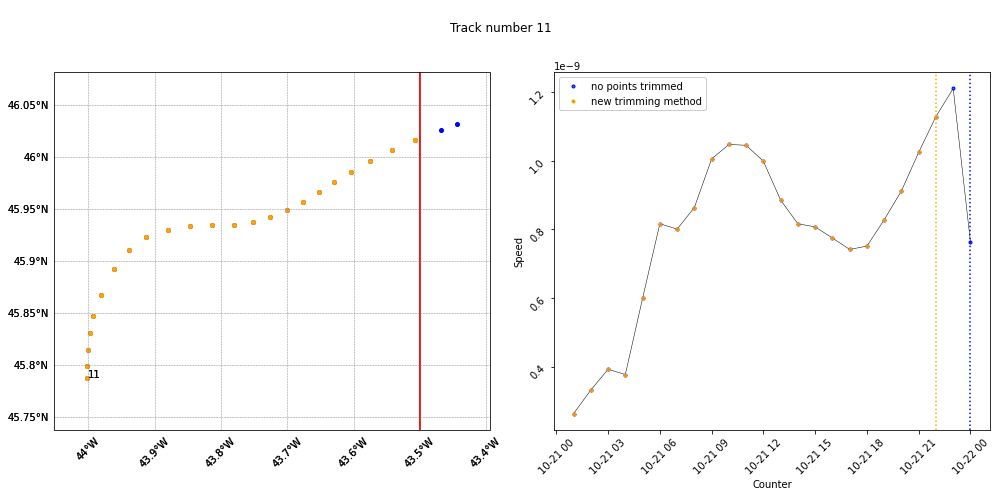

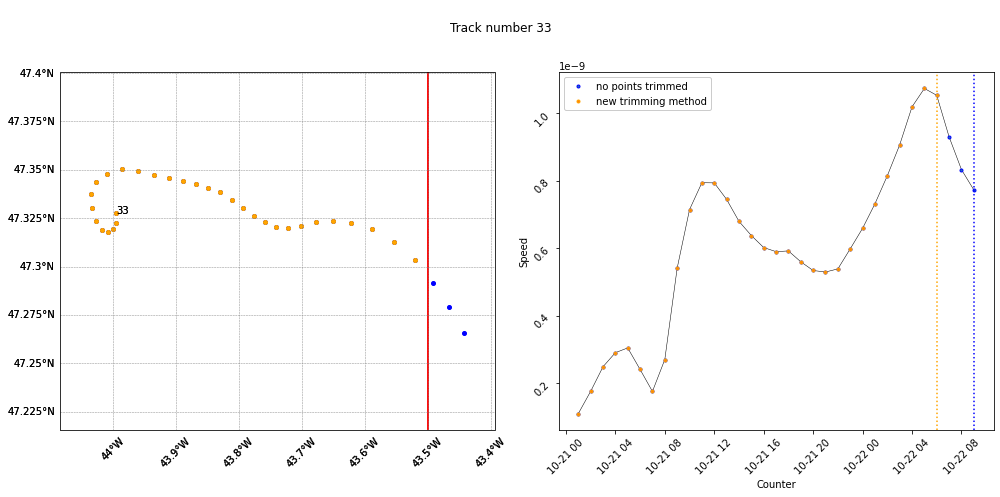

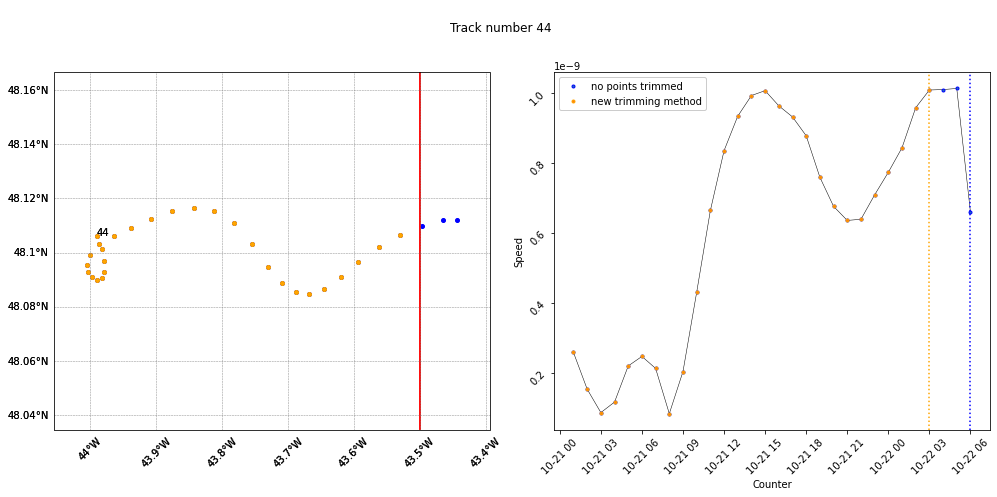

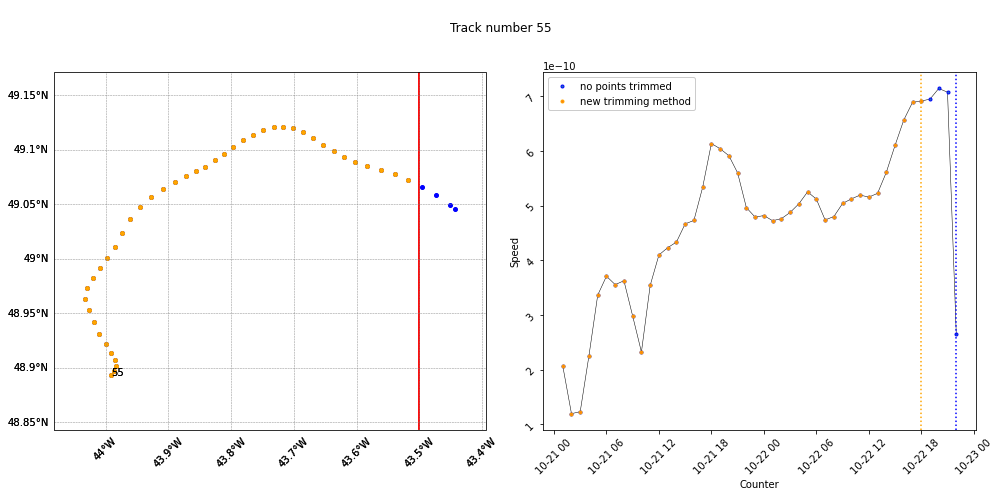

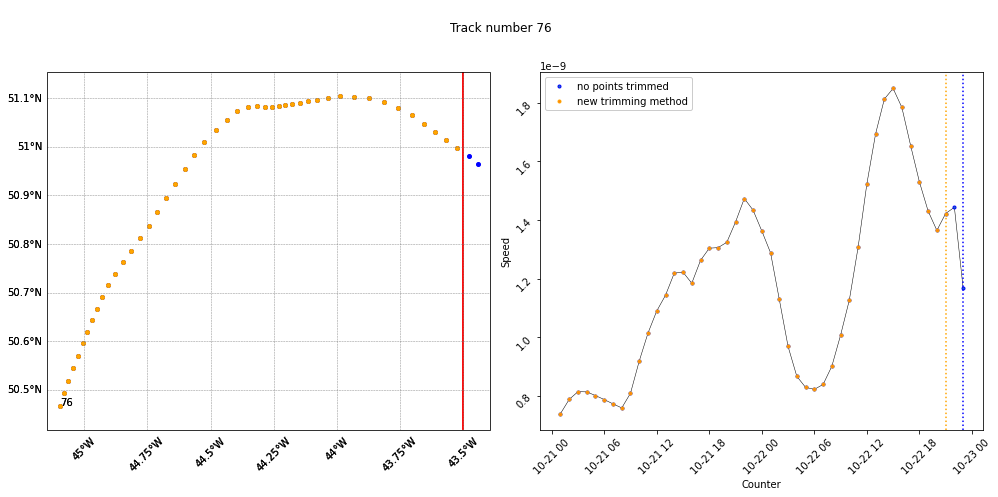

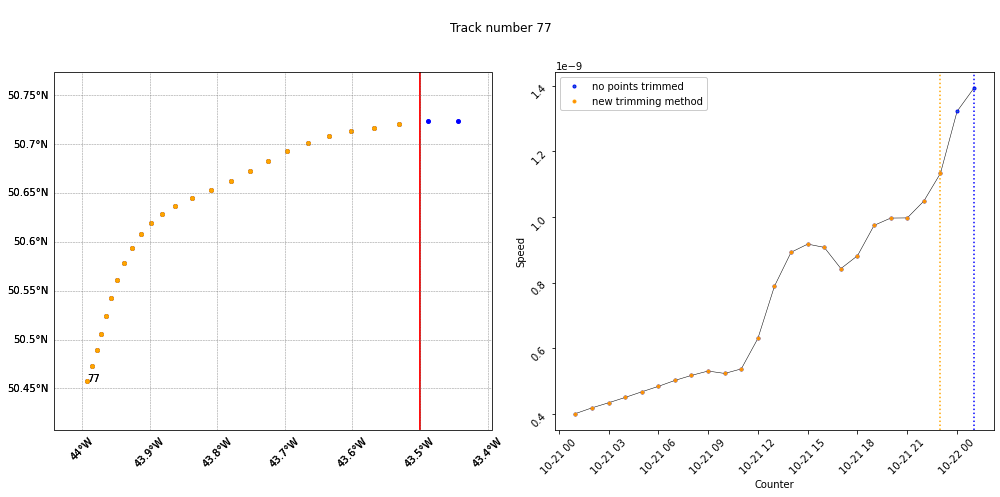

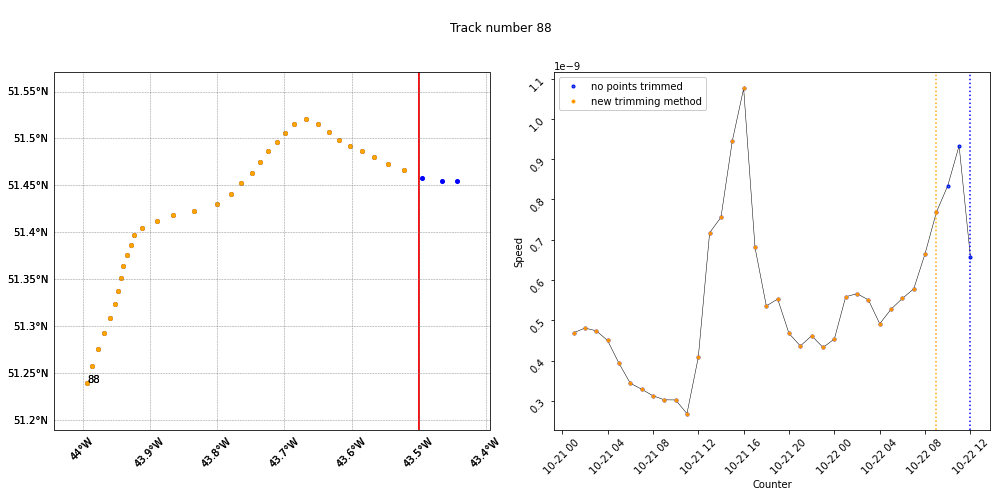

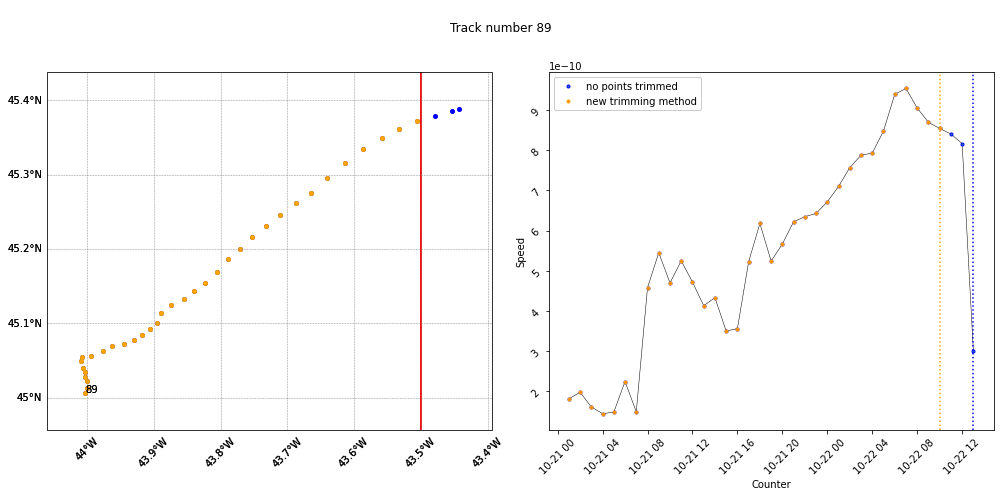

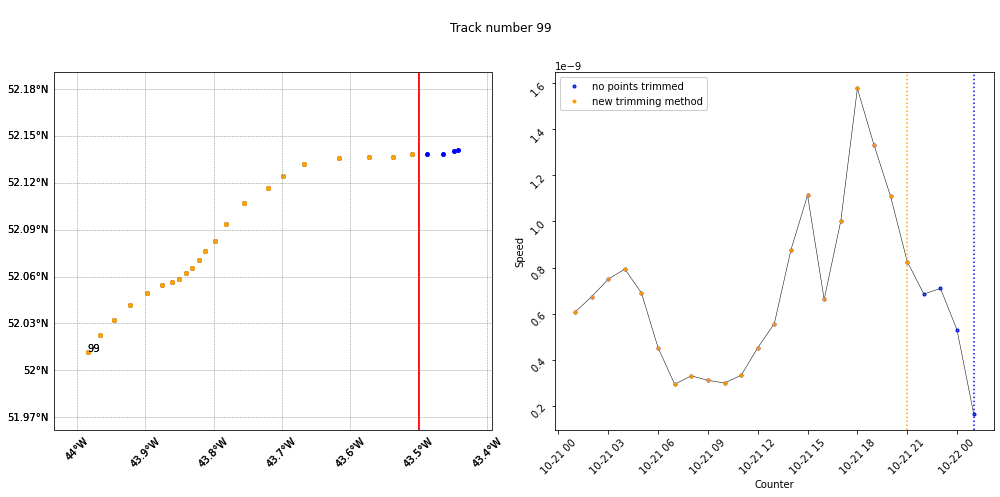

In [28]:
print('\nPlotting output from the experiment that was run on the new branch using the new track trimming method\n' )
tracklist = create_tracklist(new, new_raw)
print(str(len(tracklist)) + ' tracks were trimmed: ' + str(tracklist))

for track in tracklist:
    make_subplot([new_raw, new], 
                ['no points trimmed', 'new trimming method'], 
                track, 
                'plots_new_trimming_method')

In [29]:
print('\nPlotting output from the experiment that was run on the develop branch using the old track trimming method\n' )

tracklist = create_tracklist(dev, dev_raw)
print(str(len(tracklist)) + ' tracks were trimmed: ' + str(tracklist))

for track in tracklist:
    make_subplot([dev_raw, dev], 
                ['no points trimmed', 'trimming method on develop branch'], 
                track, 
                'plots_dev_trimming_method')


Plotting output from the experiment that was run on the develop branch using the old track trimming method

0 tracks were trimmed: []


## Here is the code that's causing the error in the driftmap plotting:

The issue is coming from the fact that the histogram plots are using the displacement value of the last timestep from each track. In the case of the data from 20211102100, all of the tracks end in NaN. The output using the develop branch has a non-NaN value for one of the tracks, which is letting the function complete without error (track 76). I don't know why that particular track doesn't have a NaN at the end when the rest of the tracks do though.

In [44]:
def plot_histogram(filename, savedir, prefix=''):
    """Plot histograms of the displacement and cumulative distance
    for DriftMap output data.

    Parameters
    ----------
    filename : str
        name of file containing the computed trajecjory longitude and latitude
        values.
    savedir : str
        name of folder in which to save the plotted output.
    """

    ds = xr.open_dataset(filename)
    print('\nplotting the histogram')

    # displacement
    print('...plotting displacement')
    fig, axs = plt.subplots(1, 2, figsize=(30, 15))
    final_disp = []
    for disp in np.ma.masked_invalid(ds.mod_disp.values):
        #rint('disp[-1] = ' + str(disp[-1]))
        if not disp.mask[-1]:
            final_disp.append(disp[-1])
            
    displacement = np.asarray(final_disp) / 1000
    print('\ndisplacement = ' + str(displacement) + '\n')  
    standard_deviation = np.nanstd(displacement)
    mean = np.mean(displacement)
    axs[0].hist(displacement, bins=20, color='#0504aa', alpha=0.7, rwidth=0.85)
    axs[0].set_xlabel('Displacement (km)', fontsize=15)
    axs[0].set_ylabel('Frequency', fontsize=15)
    tstr = r'Histogram of {}: $\mu={} $, $\sigma={} $'.format(
        ds.mod_run_name, round(mean, 4), round(standard_deviation, 4)
    )
    axs[0].set_title(tstr, fontsize=15)
    axs[0].tick_params(labelsize=15)

    xmax = displacement.max()
    
    # cumulative distance
    print('...plotting cumulative distance')
    final_dist = []
    for dist in np.ma.masked_invalid(ds.track_dist.values):
        if not dist.mask[-1]:
            final_dist.append(dist[-1])
        else:
            final_dist.append(np.nan)
    distance = np.asarray(final_dist)/1000
    standard_deviation = np.nanstd(distance)
    mean = np.nanmean(distance)
    axs[1].hist(distance, bins=20, color='#0504aa', alpha=0.7, rwidth=0.85)
    axs[1].set_xlabel('Cummulative Distance (km)', fontsize=15)
    axs[1].set_ylabel('Frequency', fontsize=15)
    tstr = r'Histogram of {}: $\mu={} $, $\sigma={} $'.format(
        ds.mod_run_name, round(mean, 4), round(standard_deviation, 4)
    )
    axs[1].set_title(tstr, fontsize=15)
    axs[1].tick_params(labelsize=15)
    xmax = max(xmax, distance.max())
    axs[0].set_xlim(0, xmax)
    axs[1].set_xlim(0, xmax)

    histogram_basename = prefix + '_disp_dist_{}.png'.format(ds.mod_run_name)
    hist_plot_filename = os.path.join(savedir, histogram_basename)
    print('\nsaving ' + str(hist_plot_filename))
    fig.savefig(hist_plot_filename, bbox_inches='tight',
                dpi=300, orientation='portrait')
    plt.show()
    plt.close(fig)


plotting the histogram
...plotting displacement

displacement = [129.14217602]

...plotting cumulative distance

saving C:/Users/HoldenJe/Drift\projects/driftmap_update/issue83_slow_predictions/reruns/histogram_plots\dev_disp_dist_ciops-e_ml_2021102100_P2D.png


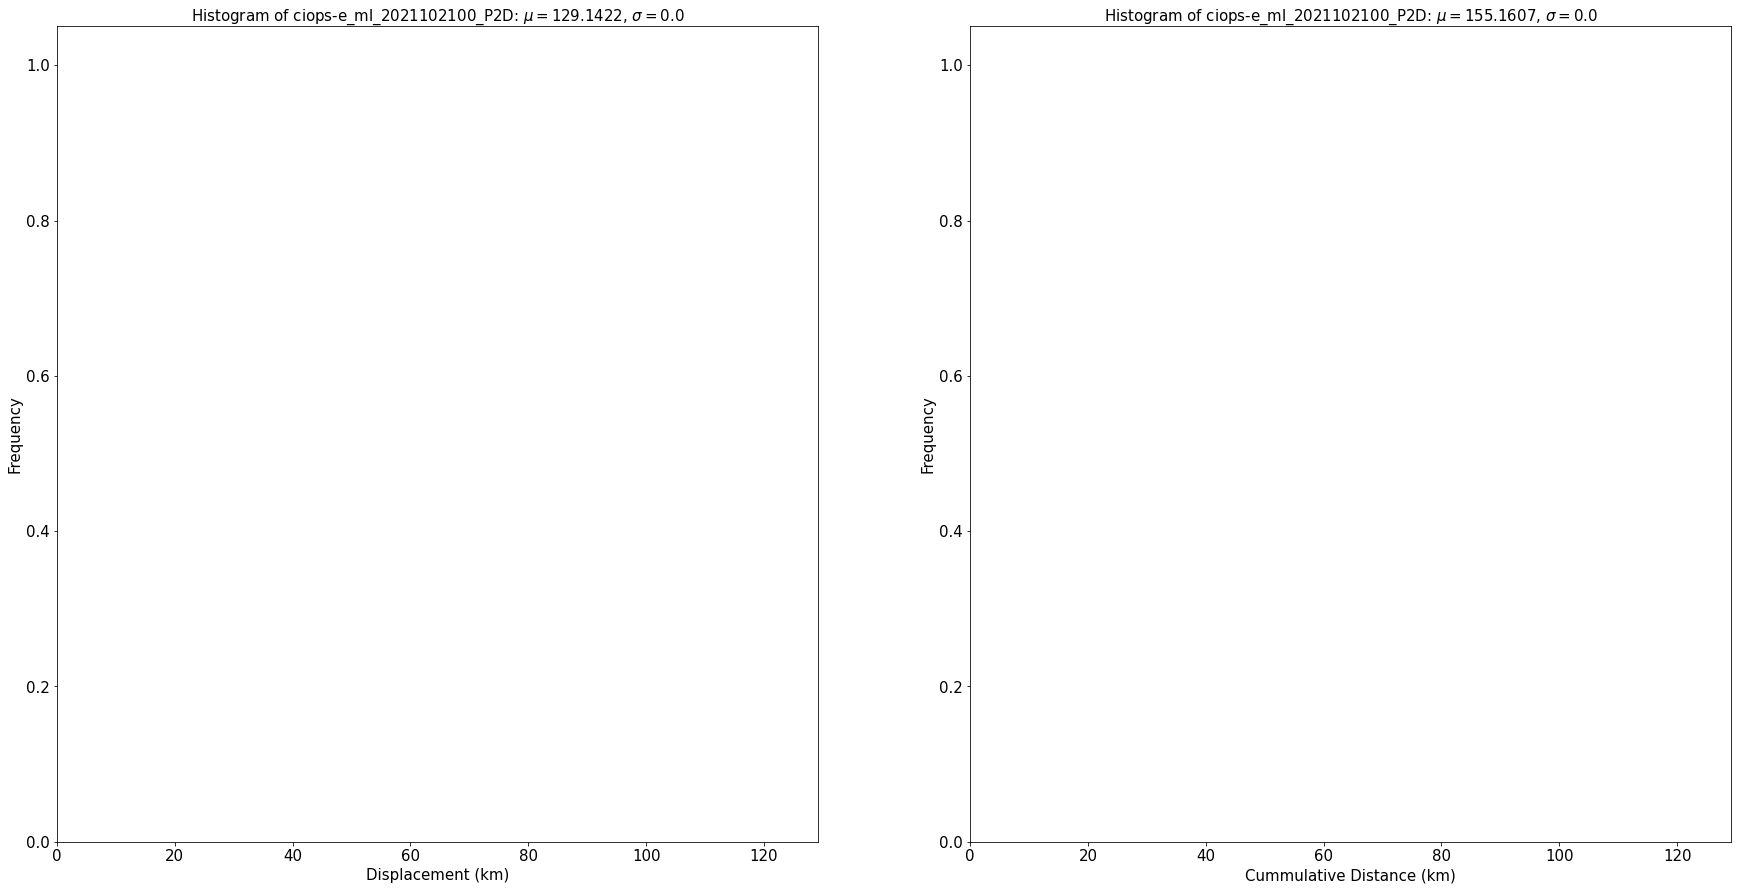

In [45]:
# This plots the histogram for the experiment performed with the develop branch. The code completes 
# without an error, but the plot itself isn't actually valid. 

histdir = os.path.join(projdir, "histogram_plots")
plot_histogram(dev_outfile, histdir, prefix='dev')


plotting the histogram
...plotting displacement

displacement = []



C:\Users\HoldenJe\Miniconda3\envs\rotary_spectra_test_env\lib\site-packages\numpy\lib\nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\HoldenJe\Miniconda3\envs\rotary_spectra_test_env\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\HoldenJe\Miniconda3\envs\rotary_spectra_test_env\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


ValueError: zero-size array to reduction operation maximum which has no identity

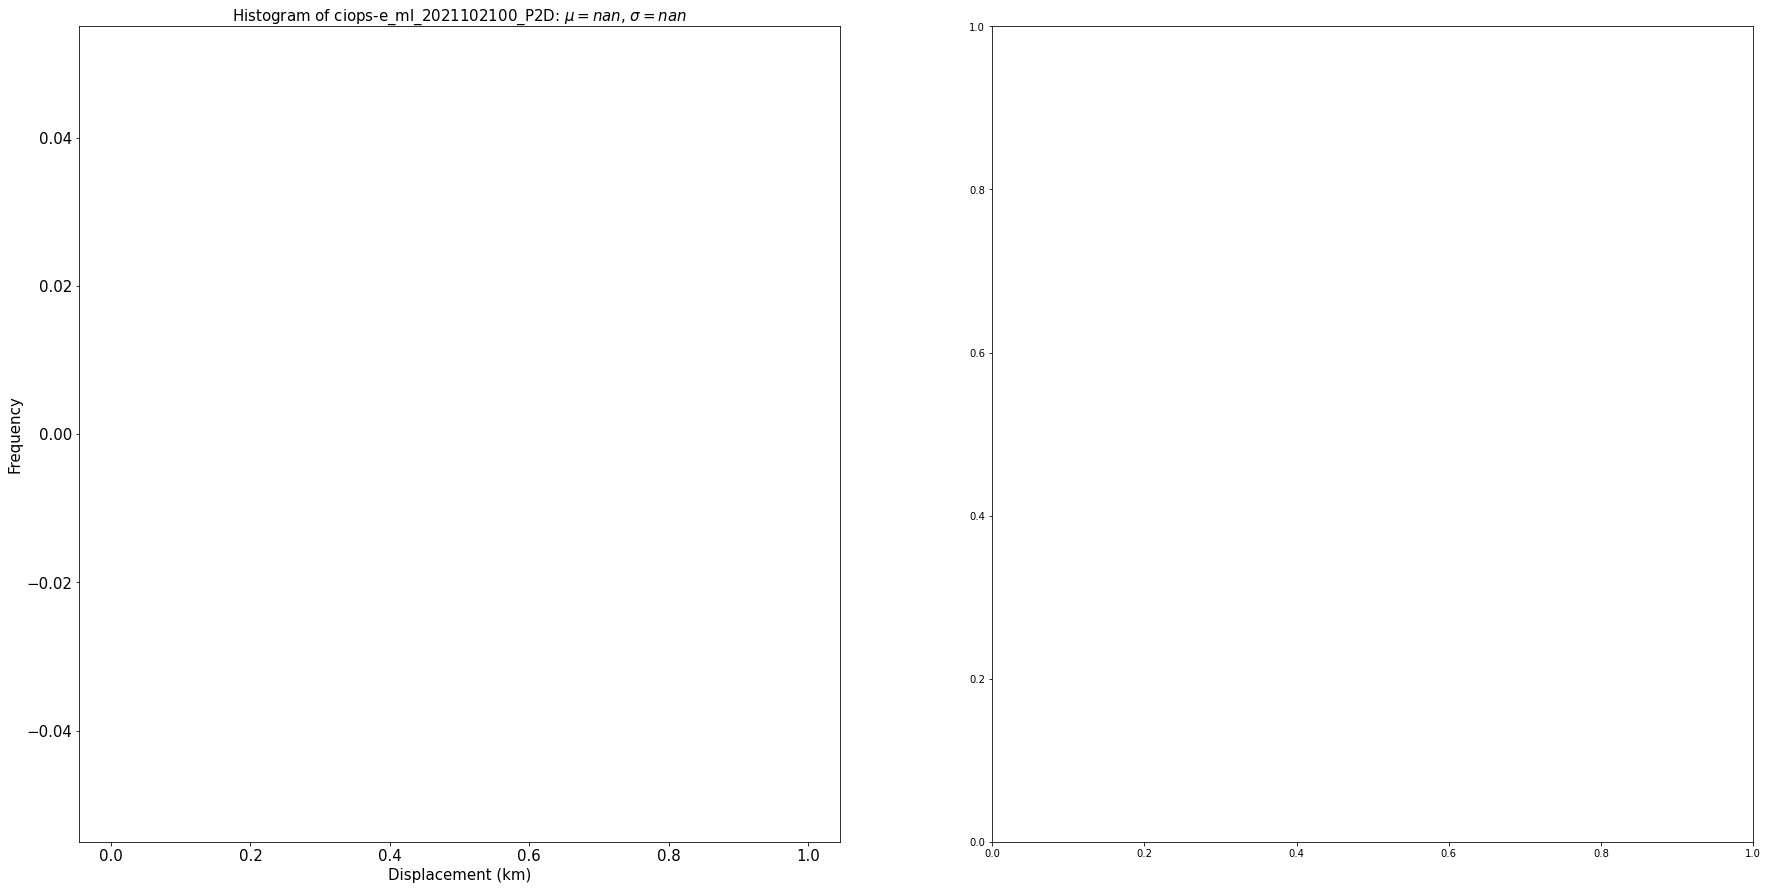

In [46]:
# here's what happens when using the output from the new branch with the new trimming method. The one
# track that didn't end in NaN in the develop case has now been trimmed, so an empty list is produced
# for displacement.

histdir = os.path.join(projdir, "histogram_plots")
plot_histogram(new_outfile, histdir, prefix='new')